## **MLPP25 // Gaussian Processes (GP) and GP Regression**

*Feb 27, 2025*

This notebook will provide a high-level overview of Gaussian Processes and an application to time series.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# -- set matplotlib stylesheet default
plt.style.use("bmh")

---

Imagine we have a Gaussian (or Normal) distribution of some mean $\mu$ and width $\sigma$, that looks like this:

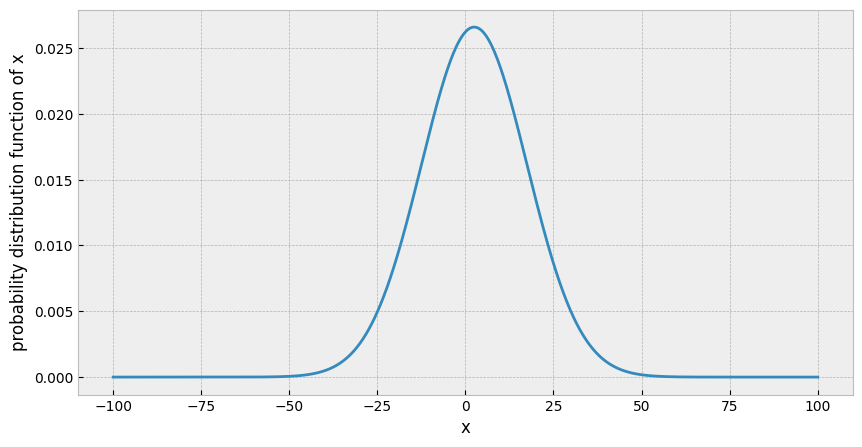

In [4]:
#@title Gaussian example
# -- define Gaussian function
def gaussian(xx, mu, sig):
  return np.exp(-(xx - mu)**2 / (2 * sig**2)) / np.sqrt(2 * np.pi * sig**2)

# -- plot example
xx  = np.linspace(-100, 100, 1000)
mu  = 2.5
sig = 15.0
gg  = gaussian(xx, mu, sig)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xx, gg)
ax.set_xlabel("x")
ax.set_ylabel("probability distribution function of x")
fig.show()

"Drawing from" that distribution produces a set of values whose histogram "matches" the distribution (given a large enough sample):

100 values drawn from Gaussian:
[ 4.99128158e+00  1.42294672e+01  1.52842764e+01 -8.10606438e+00
 -1.14748579e+01  1.57999132e+01 -8.26844871e-01  8.22585367e+00
 -9.08863163e+00  1.54448078e+01 -1.71890039e+00 -1.14788814e+01
 -4.97805875e+00  1.39648823e+01  5.37256651e+00 -6.78145746e+00
  2.74857863e+01  2.85728230e+01  2.02333940e+01  1.92906358e+01
 -2.54908226e+01 -7.04620968e+00 -8.91374640e+00  4.24607958e+01
  5.02256133e+00  5.22048770e+00  2.23203853e+01  9.06728925e+00
  5.45138754e+00 -2.04435198e+01 -2.56220589e+00 -1.19205714e+01
 -9.70032132e-01 -1.47083751e+01 -3.84418014e+00  2.24582045e+01
 -1.14175074e+01  4.07919762e+00 -1.39633495e+01 -1.05557132e+01
 -1.07435543e+01  8.48803607e+00  3.32033829e+00 -1.02434223e+01
  1.72942706e+01  6.93902860e+00  2.81477118e+01 -3.16277317e+00
 -1.60903565e+00 -1.45888608e+01 -3.56398064e+00 -1.09932522e+01
 -4.33811732e+00  5.77889697e+00  1.23846827e+01 -1.47659791e+01
 -5.58468298e-02 -1.26867319e+01  5.16442573e+00 -1.622143

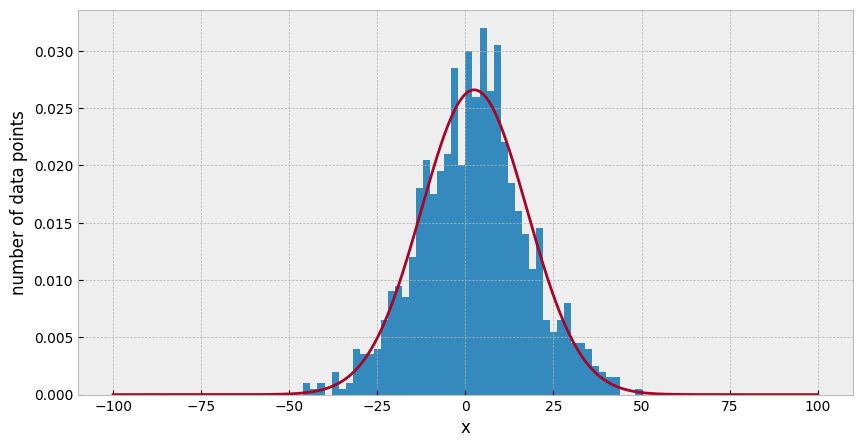

In [5]:
#@title values drawn from Gaussian
# -- draw from Gaussian
np.random.seed(314)
vals = sig * np.random.randn(1000) + mu

print("100 values drawn from Gaussian:\n{0}".format(vals))

fig, ax = plt.subplots(figsize=(10, 5))
hs = ax.hist(vals, bins=100, range=(xx[0], xx[-1]), density=True)
lin, = ax.plot(xx, gg)
ax.set_xlabel("x")
ax.set_ylabel("number of data points")
fig.show()

Now, this is a **1 dimensional** Gaussian, but we could imagine a **2 dimensional** Gaussian for example:

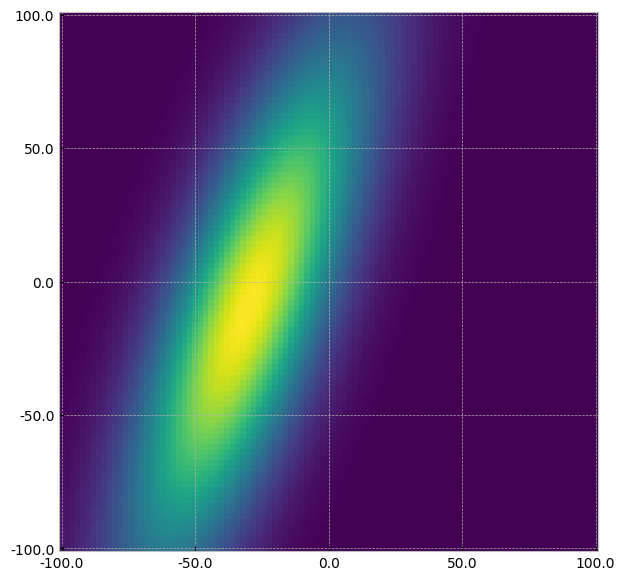

In [8]:
#@title 2D Gaussian example
# -- define 2D Gaussian
def gaussian2D(xx0, xx1, mu0, mu1, sig0, sig1, rho):
  amp  = 1.0 / (np.sqrt(1 - rho**2) * 2 * np.pi * sig0 * sig1)
  pval = (xx0 - mu0)**2 / sig0**2 + (xx1 - mu1)**2 / sig1**2 - 2 * rho * (xx0 - mu0) * (xx1 - mu1) / (sig0 * sig1)

  return amp * np.exp(-pval / 2)

# -- plot example
mu0 = 10.
mu1 = -30.
sig0 = 45.0
sig1 = 20.0
rho = -0.75
xx0 = np.linspace(-100, 100, 101)
xx1 = np.linspace(-100, 100, 101)

gg2d = np.zeros((xx0.size, xx1.size))

for ii in range(xx0.size):
  for jj in range(xx1.size):
    gg2d[ii, jj] = gaussian2D(xx0[ii], xx1[jj], mu0, mu1, sig0, sig1, rho)

fig, ax = plt.subplots(figsize=[7, 7])
ax.imshow(gg2d)
xt = [0, 25, 50, 75, 100]
ax.set_xticks(xt)
ax.set_xticklabels(xx0[xt])
ax.set_yticks(xt)
ax.set_yticklabels(0-xx0[xt])
fig.show()

Now, you can imagine drawing exactly one point from this distribution:

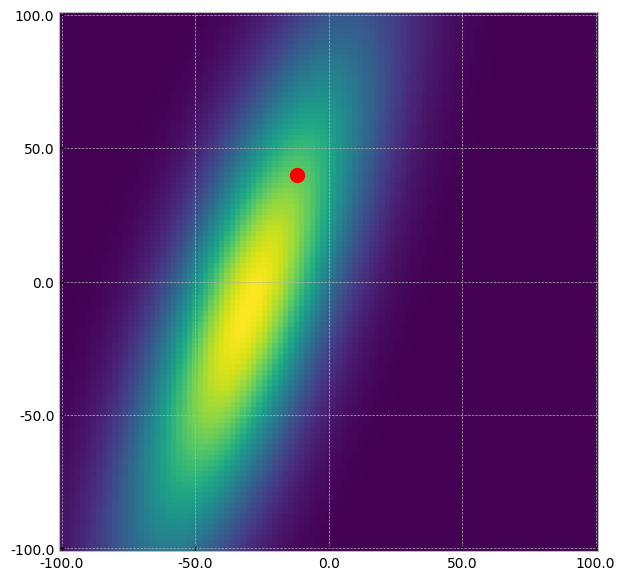

In [9]:
#@title Draw from this 2D Gaussian
fig, ax = plt.subplots(figsize=[7, 7])
ax.imshow(gg2d)
xt = [0, 25, 50, 75, 100]
ax.set_xticks(xt)
ax.set_xticklabels(xx0[xt])
ax.set_yticks(xt)
ax.set_yticklabels(0-xx0[xt])
ax.plot([44], [30], "o", color="red", markersize=10)
fig.show()

That point has two numbers associated with it, and, if those numbers happen to be *measurements* of something (say, the Dow Jones Industrial Average at two times), we can put them on a scatter plot:

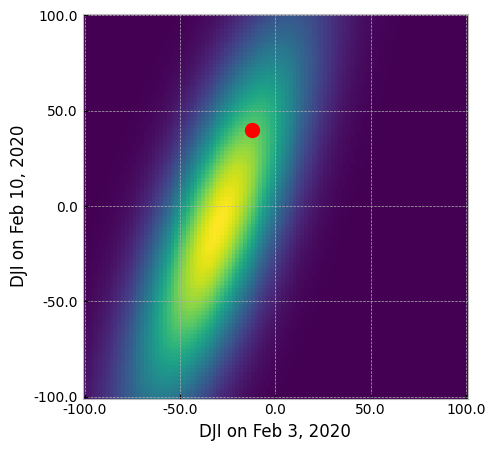

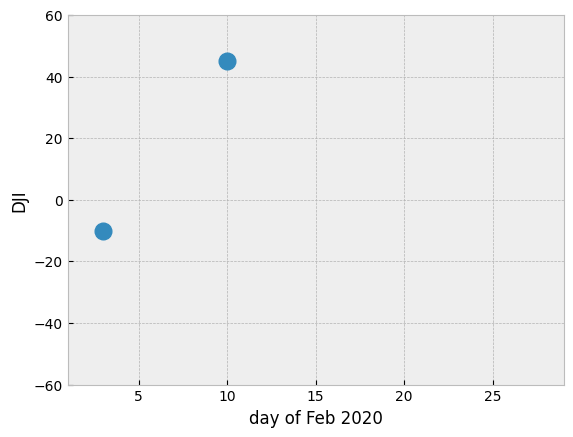

In [10]:
#@title Associating point with two measurements of a quantity
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(gg2d)
xt = [0, 25, 50, 75, 100]
ax.set_xticks(xt)
ax.set_xticklabels(xx0[xt])
ax.set_yticks(xt)
ax.set_yticklabels(0-xx0[xt])
ax.plot([44], [30], "o", color="red", markersize=10)
ax.set_xlabel("DJI on Feb 3, 2020")
ax.set_ylabel("DJI on Feb 10, 2020")
fig.show()

fig, ax = plt.subplots()
ax.plot([3, 10], [-10, 45], "o", ms=12)
ax.set_xlim(1, 29)
ax.set_ylim([-60, 60])
ax.set_xlabel("day of Feb 2020")
ax.set_ylabel("DJI")
fig.show()

Note what we've done here, we've made an **"association"** between those two days.  That association is that the values on those two days are a draw from a 2D Gaussian **with some "covariance"** (i.e., when Feb 3 is high, Feb 10 is also likely to be high [with some offset]).

But now let's look at it in a different way.  Imagine we measured Feb 3 but not Feb 10th, what is our likely value for Feb 10th?

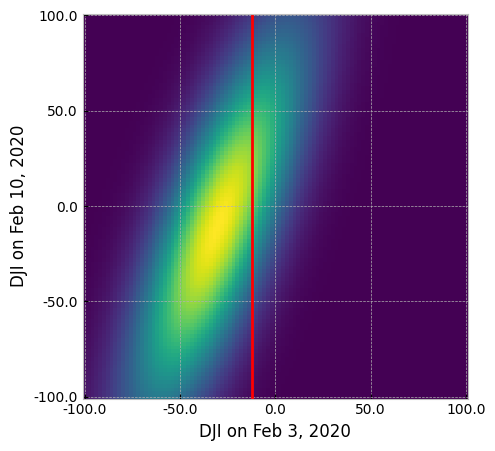

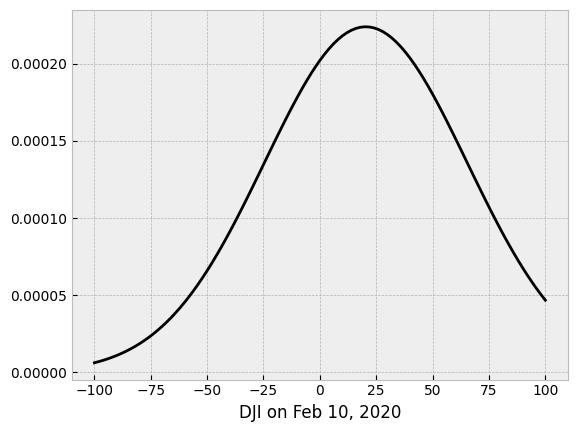

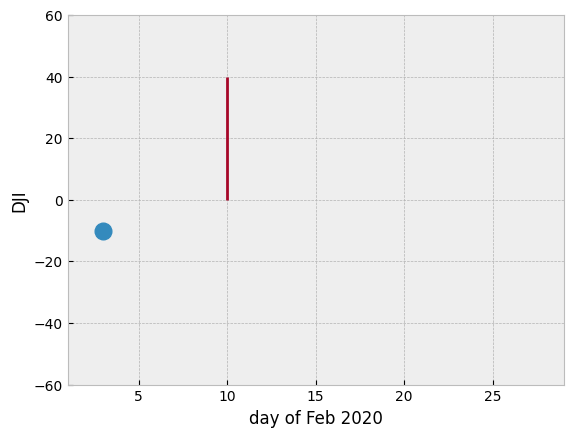

In [11]:
#@title Marginalizing over one dimension
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(gg2d)
xt = [0, 25, 50, 75, 100]
ax.set_xticks(xt)
ax.set_xticklabels(xx0[xt])
ax.set_yticks(xt)
ax.set_yticklabels(0-xx0[xt])
ax.axvline(44, color="red", lw=2)
ax.set_xlabel("DJI on Feb 3, 2020")
ax.set_ylabel("DJI on Feb 10, 2020")
fig.show()

fig, ax = plt.subplots()
ax.plot(-xx0, gg2d[:, 44], color="k")
ax.set_xlabel("DJI on Feb 10, 2020")
fig.show()

fig, ax = plt.subplots()
ax.plot([3], [-10], "o", ms=12)
ax.errorbar([10], [-xx1[gg2d[:, 44].argmax()]], yerr=20)
ax.set_xlim(1, 29)
ax.set_ylim([-60, 60])
ax.set_xlabel("day of Feb 2020")
ax.set_ylabel("DJI")
fig.show()

But now, what if we don't want to assume the association between Feb 3, 2020 and Feb 10, 2020, but rather want to **learn** it from many data points?

---

**Let's look at the DJI example with real data.**

In [12]:
# -- load data from Yahoo Finance
fname = "/content/drive/Shareddrives/mlpp25/data/dji/DJI.csv"
dji = pd.read_csv(fname)
dji

# -- get time since Feb 1st, 2020
dji["dtime"] = (pd.to_datetime(dji["Date"]) - datetime.datetime(2020, 2,1,0,0,0)).dt.days
dji

,Date,Open,High,Low,Close,Adj Close,Volume,dtime
0,2019-03-05,25829.070313,25877.150391,25725.630859,25806.630859,25806.630859,252260000,-333
1,2019-03-06,25818.759766,25837.609375,25633.710938,25673.460938,25673.460938,256250000,-332
2,2019-03-07,25645.449219,25645.449219,25352.550781,25473.230469,25473.230469,289140000,-331
3,2019-03-08,25347.380859,25466.140625,25252.460938,25450.240234,25450.240234,270500000,-330
4,2019-03-11,25208.000000,25661.630859,25208.000000,25650.880859,25650.880859,309790000,-327
...,...,...,...,...,...,...,...,...
249,2020-02-28,25270.830078,25494.240234,24681.009766,25409.359375,25409.359375,915990000,27
250,2020-03-02,25590.509766,26706.169922,25391.960938,26703.320313,26703.320313,637200000,30
251,2020-03-03,26762.470703,27084.589844,25706.279297,25917.410156,25917.410156,647080000,31
252,2020-03-04,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,457590000,32


In [13]:
dji["Date"].iloc[0] #that is a string

'2019-03-05'

<Axes: xlabel='Date'>

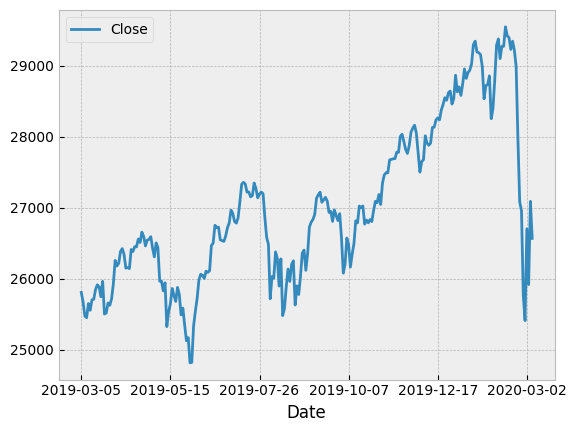

In [14]:
dji.plot("Date", "Close")

In [ ]:
#scikit doesnt like strings. gaussian doesnt like working with strings.

In [15]:
datetime.datetime(2020, 2,1,0,0,0)

datetime.datetime(2020, 2, 1, 0, 0)

In [16]:
(pd.to_datetime(dji["Date"]) - datetime.datetime(2020, 2,1,0,0,0)).dt.days

,Date
0,-333
1,-332
2,-331
3,-330
4,-327
...,...
249,27
250,30
251,31
252,32


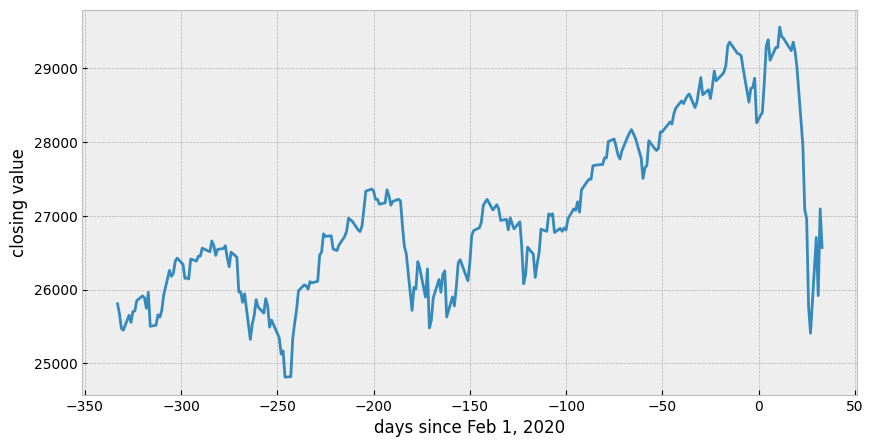

In [17]:
# -- plot the time series of the "closing" values
ax = dji.plot("dtime", "Close", legend=False,
              ylabel="closing value", xlabel="days since Feb 1, 2020",
              figsize=(10, 5))

In [18]:
dji["Close"].values

array([25806.630859, 25673.460938, 25473.230469, 25450.240234,
       25650.880859, 25554.660156, 25702.890625, 25709.939453,
       25848.869141, 25914.099609, 25887.380859, 25745.669922,
       25962.509766, 25502.320313, 25516.830078, 25657.730469,
       25625.589844, 25717.460938, 25928.679688, 26258.419922,
       26179.130859, 26218.130859, 26384.630859, 26424.990234,
       26341.019531, 26150.580078, 26157.160156, 26143.050781,
       26412.300781, 26384.769531, 26452.660156, 26449.539063,
       26559.539063, 26511.050781, 26656.390625, 26597.050781,
       26462.080078, 26543.330078, 26554.390625, 26592.910156,
       26430.140625, 26307.789063, 26504.949219, 26438.480469,
       25965.089844, 25967.330078, 25828.359375, 25942.369141,
       25324.990234, 25532.050781, 25648.019531, 25862.679688,
       25764.      , 25679.900391, 25877.330078, 25776.609375,
       25490.470703, 25585.689453, 25347.769531, 25126.410156,
       25169.880859, 24815.039063, 24819.779297, 25332.

In [19]:
djicl = dji["Close"].values
djicl[:9]

array([25806.630859, 25673.460938, 25473.230469, 25450.240234,
       25650.880859, 25554.660156, 25702.890625, 25709.939453,
       25848.869141])

In [20]:
djicl[1:10]

array([25673.460938, 25473.230469, 25450.240234, 25650.880859,
       25554.660156, 25702.890625, 25709.939453, 25848.869141,
       25914.099609])

In [21]:
djicl[:-1] #values till last day

array([25806.630859, 25673.460938, 25473.230469, 25450.240234,
       25650.880859, 25554.660156, 25702.890625, 25709.939453,
       25848.869141, 25914.099609, 25887.380859, 25745.669922,
       25962.509766, 25502.320313, 25516.830078, 25657.730469,
       25625.589844, 25717.460938, 25928.679688, 26258.419922,
       26179.130859, 26218.130859, 26384.630859, 26424.990234,
       26341.019531, 26150.580078, 26157.160156, 26143.050781,
       26412.300781, 26384.769531, 26452.660156, 26449.539063,
       26559.539063, 26511.050781, 26656.390625, 26597.050781,
       26462.080078, 26543.330078, 26554.390625, 26592.910156,
       26430.140625, 26307.789063, 26504.949219, 26438.480469,
       25965.089844, 25967.330078, 25828.359375, 25942.369141,
       25324.990234, 25532.050781, 25648.019531, 25862.679688,
       25764.      , 25679.900391, 25877.330078, 25776.609375,
       25490.470703, 25585.689453, 25347.769531, 25126.410156,
       25169.880859, 24815.039063, 24819.779297, 25332.

In [22]:
djicl[1:]

array([25673.460938, 25473.230469, 25450.240234, 25650.880859,
       25554.660156, 25702.890625, 25709.939453, 25848.869141,
       25914.099609, 25887.380859, 25745.669922, 25962.509766,
       25502.320313, 25516.830078, 25657.730469, 25625.589844,
       25717.460938, 25928.679688, 26258.419922, 26179.130859,
       26218.130859, 26384.630859, 26424.990234, 26341.019531,
       26150.580078, 26157.160156, 26143.050781, 26412.300781,
       26384.769531, 26452.660156, 26449.539063, 26559.539063,
       26511.050781, 26656.390625, 26597.050781, 26462.080078,
       26543.330078, 26554.390625, 26592.910156, 26430.140625,
       26307.789063, 26504.949219, 26438.480469, 25965.089844,
       25967.330078, 25828.359375, 25942.369141, 25324.990234,
       25532.050781, 25648.019531, 25862.679688, 25764.      ,
       25679.900391, 25877.330078, 25776.609375, 25490.470703,
       25585.689453, 25347.769531, 25126.410156, 25169.880859,
       24815.039063, 24819.779297, 25332.179688, 25539.

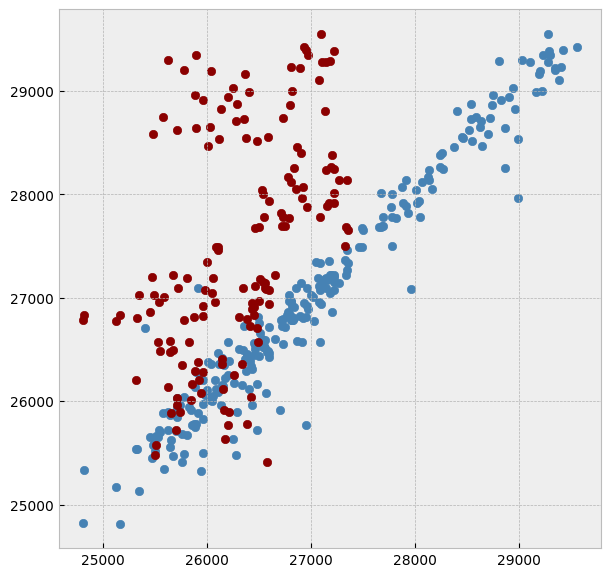

In [23]:
# -- let's look at the data distributions by scatter plotting different lags


# -- initialize the plot
fig, ax = plt.subplots(figsize=[7, 7])

# -- plot DJI values for all t on x-axis and all t+1 on y-axis
#values separated by a day
ax.scatter(djicl[:-1], djicl[1:], c="steelblue") #x-axis=values till last day; y-axis=values from day later

#it is seen that they are correlated.  (blue points)



# -- plot DJI values for all t on x-axis and all t+100 on y-axis
#values separated by 100 days
ax.scatter(djicl[:-100], djicl[100:], c="darkred")

#they are uncorrelated.

fig.show()

In [24]:
# -- subset only since Feb 1, 2020
dji=dji[dji["dtime"]>0]
dji

,Date,Open,High,Low,Close,Adj Close,Volume,dtime
231,2020-02-03,28319.650391,28630.390625,28319.650391,28399.810547,28399.810547,307910000,2
232,2020-02-04,28696.740234,28904.880859,28696.740234,28807.630859,28807.630859,332750000,3
233,2020-02-05,29048.730469,29308.890625,29000.849609,29290.849609,29290.849609,357540000,4
234,2020-02-06,29388.580078,29408.050781,29246.929688,29379.769531,29379.769531,263700000,5
235,2020-02-07,29286.919922,29286.919922,29056.980469,29102.509766,29102.509766,252860000,6
236,2020-02-10,28995.660156,29278.070313,28995.660156,29276.820313,29276.820313,250510000,9
237,2020-02-11,29390.710938,29415.390625,29210.470703,29276.339844,29276.339844,279540000,10
238,2020-02-12,29406.750000,29568.570313,29406.750000,29551.419922,29551.419922,309530000,11
239,2020-02-13,29436.029297,29535.400391,29345.929688,29423.310547,29423.310547,291150000,12
240,2020-02-14,29440.470703,29463.039063,29283.179688,29398.080078,29398.080078,231000000,13


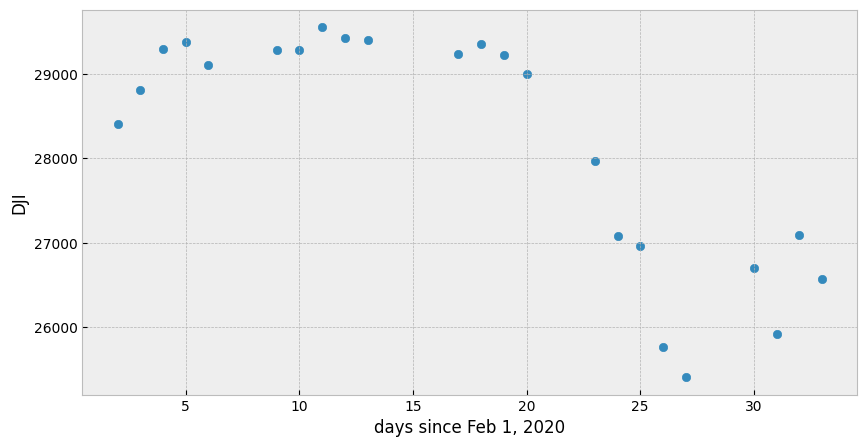

In [25]:
# -- plot it
fig, ax = plt.subplots(figsize=[10, 5])
ax.scatter(dji["dtime"], dji["Close"])
ax.set_xlabel("days since Feb 1, 2020")
ax.set_ylabel("DJI")
fig.show()

In [26]:
# -- let's take the difference for every possible dtime interval combination
npts = len(dji)
ddji = [] #close values
tint = [] #time interval

for ii in range(npts):
  for jj in range(ii, npts):
    ddji.append(dji["Close"].iloc[jj] - dji["Close"].iloc[ii])
    tint.append(dji["dtime"].iloc[jj] - dji["dtime"].iloc[ii])

# -- put those in a DataFrame
df = pd.DataFrame()
df["tint"] = tint
df["ddji"] = ddji

In [27]:
df

,tint,ddji
0,0,0.000000
1,1,407.820312
2,2,891.039062
3,3,979.958984
4,4,702.699219
...,...,...
271,1,1173.449219
272,2,651.089844
273,0,0.000000
274,1,-522.359375


In [28]:
df.groupby("tint").mean() #grouping the points by the time interval (1 day diff, 2 day diff, ...) and taking their mean

,ddji
tint,
0,0.000000
1,-116.782335
2,-127.099309
3,-205.548118
4,-354.799219
5,-353.853693
6,-505.770573
7,-704.417739
8,-789.555804


In [29]:
# -- group by tint
dfg = df.groupby("tint").mean().reset_index()
dfg

,tint,ddji
0,0,0.000000
1,1,-116.782335
2,2,-127.099309
3,3,-205.548118
4,4,-354.799219
5,5,-353.853693
6,6,-505.770573
7,7,-704.417739
8,8,-789.555804
9,9,-745.666016


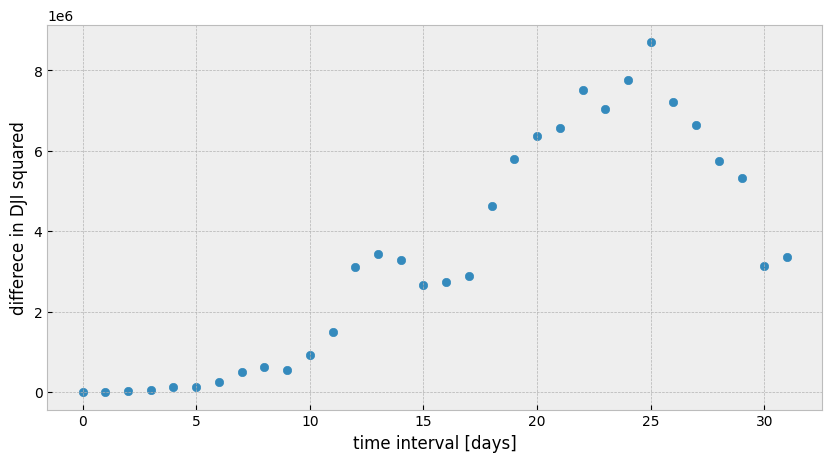

In [30]:
# -- plot
fig, ax = plt.subplots(figsize=[10, 5])
ax.scatter(dfg["tint"], dfg["ddji"]**2)
ax.set_xlabel("time interval [days]")
ax.set_ylabel("differece in DJI squared")
fig.show()

as time interval increases, average difference gets bigger.

This relationship is what is to be modeled.  For example with the "Radial Basis Function" (RBF) kernel:

$k(\mbox{interval}) \propto \exp(-\frac{1}{2} \ \mbox{interval}^2)$

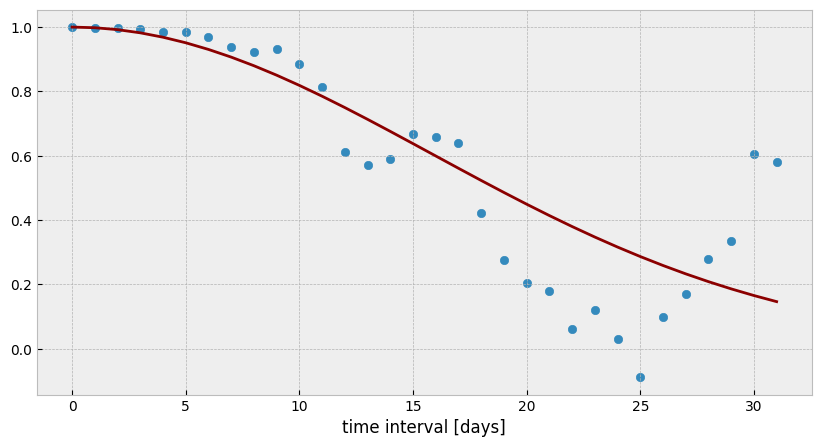

In [31]:
# -- overplot RBF
fig, ax = plt.subplots(figsize=[10, 5])
ax.scatter(dfg["tint"], 1 - dfg["ddji"]**2 / 8000000)
ax.plot(dfg["tint"], np.exp(-0.5 * dfg["tint"]**2 / 250), color="darkred")

ax.set_xlabel("time interval [days]")
fig.show()

In [32]:
np.linspace(-10,10)#gives some values between -10, 10

array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
        -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
        -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
        -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
        -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
        -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
        -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
         1.42857143,   1.83673469,   2.24489796,   2.65306122,
         3.06122449,   3.46938776,   3.87755102,   4.28571429,
         4.69387755,   5.10204082,   5.51020408,   5.91836735,
         6.32653061,   6.73469388,   7.14285714,   7.55102041,
         7.95918367,   8.36734694,   8.7755102 ,   9.18367347,
         9.59183673,  10.        ])

In [34]:
np.linspace(-10,10,50) # can specify the number of values u want [50]

array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
        -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
        -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
        -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
        -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
        -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
        -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
         1.42857143,   1.83673469,   2.24489796,   2.65306122,
         3.06122449,   3.46938776,   3.87755102,   4.28571429,
         4.69387755,   5.10204082,   5.51020408,   5.91836735,
         6.32653061,   6.73469388,   7.14285714,   7.55102041,
         7.95918367,   8.36734694,   8.7755102 ,   9.18367347,
         9.59183673,  10.        ])

In [35]:
# -- so let's actually fit this data by importing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# -- create the features and target
feat = dji[["dtime"]]
targ = dji[["Close"]]

# -- standardize those
feat_st = (feat-feat.mean())/feat.std()
targ_st = (targ-targ.mean())/targ.std()

# -- create a Gaussian process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#C(1.0 [GUESS], (1e-3, 1e3) [RANGE]) * RBF(10, (1e-2, 1e2)) [HOW FAST THETHINGFALLS OFF]
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.015) #works well if it restarts some no. of times.

# -- fit the GP model
gpr.fit(feat_st, targ_st)

# -- predict
dji_model_st = pd.DataFrame()
dji_model_st["dtime"] = np.linspace(-2, 2, 100)
pred_st, sigma = gpr.predict(dji_model_st[["dtime"]], return_std=True) #return_std=True gives uncertaininty

In [36]:
dji_model_st

,dtime
0,-2.000000
1,-1.959596
2,-1.919192
3,-1.878788
4,-1.838384
...,...
95,1.838384
96,1.878788
97,1.919192
98,1.959596


In [37]:
sigma

array([0.72905269, 0.68762348, 0.63980643, 0.5861201 , 0.52749481,
       0.46526038, 0.40110142, 0.33698688, 0.27508805, 0.21770828,
       0.16725319, 0.12623702, 0.09708377, 0.08087339, 0.07507151,
       0.07427729, 0.07423106, 0.07351912, 0.07287514, 0.07395734,
       0.07798612, 0.08476534, 0.09282861, 0.10030099, 0.10558749,
       0.1076784 , 0.10624082, 0.10161842, 0.09476583, 0.08708792,
       0.08011781, 0.07500674, 0.07204291, 0.07067551, 0.07018535,
       0.07048215, 0.07242757, 0.07736436, 0.08602023, 0.0977508 ,
       0.11080822, 0.12308807, 0.13269527, 0.13824165, 0.13898543,
       0.13487692, 0.12652971, 0.11512589, 0.10226686, 0.0897794 ,
       0.07946507, 0.07275336, 0.07030138, 0.07182935, 0.0764126 ,
       0.08290771, 0.09014504, 0.09696139, 0.10226283, 0.10516149,
       0.10513543, 0.10215289, 0.09672095, 0.08982974, 0.08276155,
       0.07674544, 0.07253675, 0.07019528, 0.06932953, 0.06964734,
       0.07131853, 0.07482586, 0.08041054, 0.08760028, 0.09522

In [38]:
pred_st

array([-0.4584878 , -0.48856097, -0.50712544, -0.51109404, -0.49777491,
       -0.4651572 , -0.41218031, -0.33895359, -0.24689365, -0.13875193,
       -0.01851448,  0.10883017,  0.23764341,  0.36208099,  0.47658707,
        0.57638554,  0.65791248,  0.71913756,  0.75973308,  0.78106659,
        0.7860146 ,  0.77861678,  0.76361099,  0.74590427,  0.73004324,
        0.71974695,  0.71755604,  0.72463677,  0.74075714,  0.76443041,
        0.79319996,  0.82402263,  0.85369722,  0.87928156,  0.89844642,
        0.90972531,  0.91263527,  0.90766202,  0.89612088,  0.87992054,
        0.86126761,  0.84235552,  0.82508016,  0.81081807,  0.8002917 ,
        0.79353188,  0.78993278,  0.78838062,  0.78742746,  0.78547569,
        0.78093931,  0.77235424,  0.75842071,  0.73797529,  0.70990485,
        0.67302863,  0.62598381,  0.5671532 ,  0.49466992,  0.40652273,
        0.30076878,  0.17584018,  0.03091016, -0.13373235, -0.31636121,
       -0.51360688, -0.72041833, -0.93022649, -1.13531575, -1.32

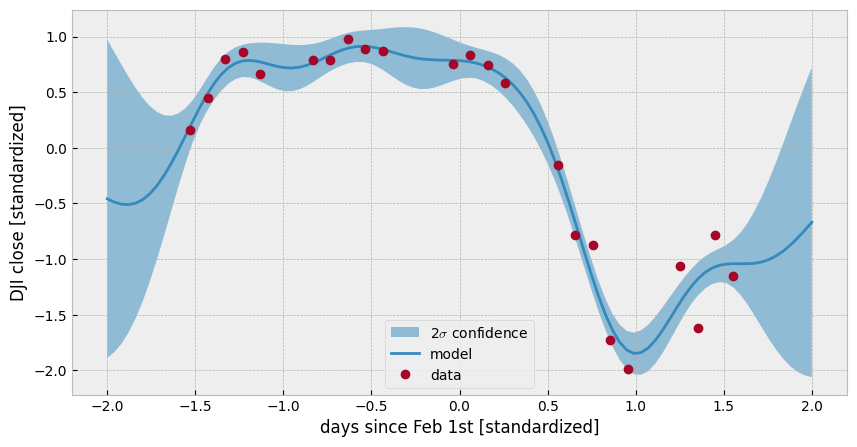

In [39]:
# -- plot the result
fig, ax = plt.subplots(figsize=[10, 5])
ax.fill_between(dji_model_st["dtime"], pred_st + 1.96 * sigma, pred_st - 1.96 * sigma, alpha=0.5, label="2$\sigma$ confidence")
ax.plot(dji_model_st["dtime"], pred_st, label="model")
ax.plot(feat_st["dtime"], targ_st, "o", label="data")
ax.set_xlabel("days since Feb 1st [standardized]")
ax.set_ylabel("DJI close [standardized]")
ax.legend()
fig.show()
